In [1]:
#load library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.sparse import load_npz
from scipy.spatial.distance import cosine


In [2]:
#load data
smiles_list = np.load('H:/yang/FastEI/response/data_response/2146690_smiles.npy')
true_smiles = pd.read_csv('H:/yang/FastEI/response/data_response/11499_test_2146690index.csv')
true_vectors = np.load('H:/yang/FastEI/response/data_response/test11499_mainbinning1000_vectors.npy')
true_embeds = load_npz('H:/yang/FastEI/response/data_response/testmain_meassured_word_sg.npz').todense()

res_fastei = np.load('H:/yang/FastEI/response/data_response/11499main_spectrum2146690_index_results.npy')
res_wcs = np.load('H:/yang/FastEI/response/data_response/wcs_test_11499_results.npy')
candidate_vector = np.load('H:/yang/FastEI/response/data_response/2253216_binning_vectors.npy')
candidate_embeds = load_npz('H:/yang/FastEI/response/data_response/all_2253216_predicted_word_sg.npz').todense()


100%|█████████████████████████████████████████████████████████████████████████| 11499/11499 [00:00<00:00, 15779.51it/s]


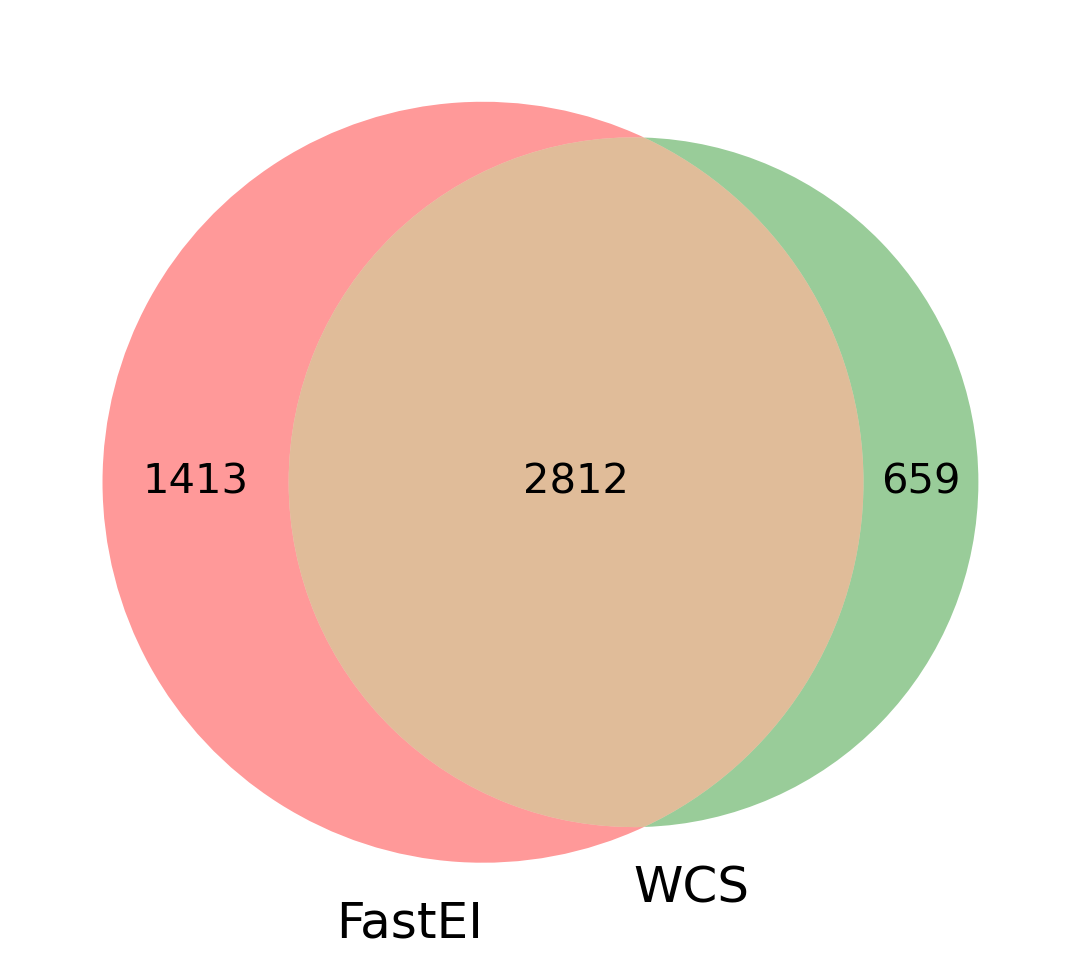

In [3]:

#plot Venn diagram of the recall@1 molecules of FastEI and WCS.
true_by_fastei, true_by_wcs = [], []
for i in tqdm(true_smiles.index):
    sm = true_smiles.loc[i,'sdf_smiles']
    index = true_smiles.loc[i, '2146690_index']
    w1 = np.where(res_fastei[i,:] == index)[0]
    w2 = np.where(res_wcs[i,:] == index)[0]
    
    if len(w1 > 0):
        if w1[0] + 1 == 1:
            true_by_fastei.append(sm)
            
    if len(w2 > 0):
        if w2[0] + 1 == 1:
            true_by_wcs.append(sm)
            
from matplotlib_venn import venn2
plt.figure(dpi = 300)
venn2([set(true_by_fastei), set(true_by_wcs)], ['FastEI', 'WCS'])


100%|████████████████████████████████████████████████████████████████████████████| 11499/11499 [03:17<00:00, 58.15it/s]


<AxesSubplot:xlabel='Method', ylabel='Cosine similarity'>

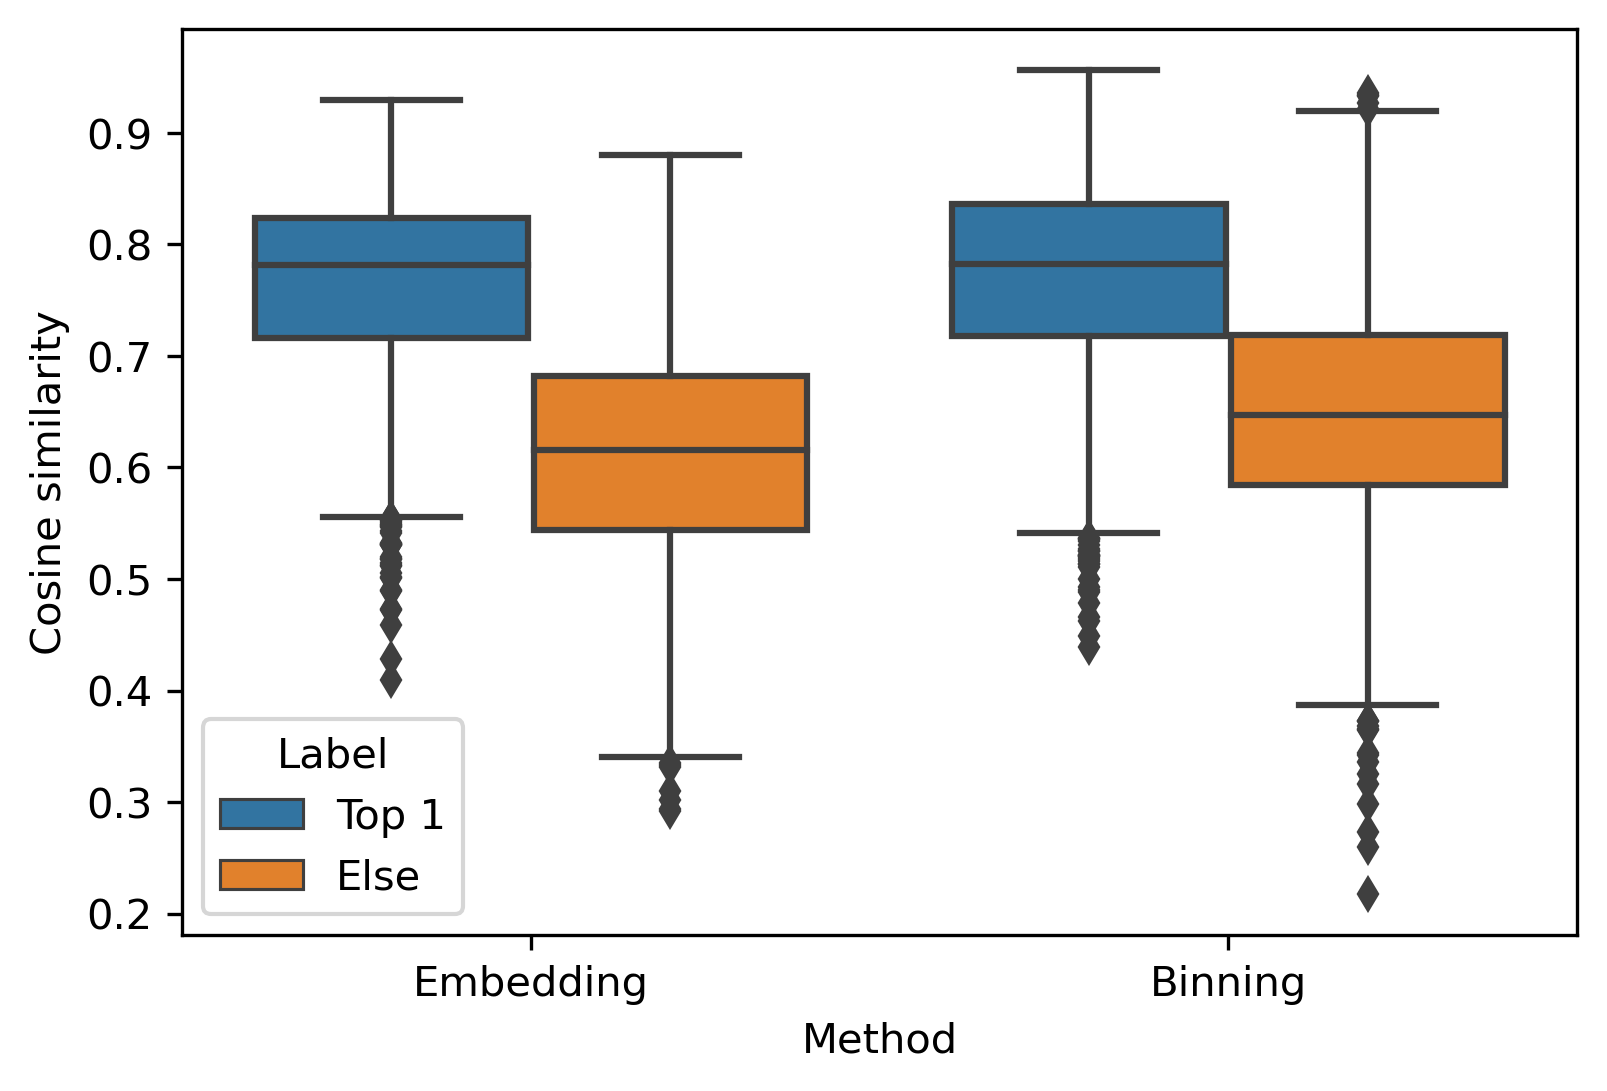

In [4]:
#plot left: box plot of the spectral embedding similarities of top1 candidates are 
#compared with the embedding similarities of other candidates (the top10 except for top1); 
#plot right: box plot of the spectral binning similarities of top1 candidates are 
#compared with the spectral binning similarities of other candidates (the top10 except for top1).
cosine_embed, cosine_bin = [], []
cosine_embed_else, cosine_bin_else = [], []
for i in tqdm(true_smiles.index):
    sm = true_smiles.loc[i,'sdf_smiles']
    index = true_smiles.loc[i, '2146690_index']
    w1 = np.where(res_fastei[i,:] == index)[0]
    w2 = np.where(res_wcs[i,:] == index)[0]
    
    v = true_vectors[i]
    e = true_embeds[i]
    j = res_fastei[i, 0]
    v1 = candidate_vector[j]
    e1 = candidate_embeds[j]
    cos_v = 1 - cosine(v, v1)
    cos_e = 1 - cosine(e, e1)
    
    cos_v_else = np.mean([1 - cosine(v, candidate_vector[j]) for j in res_fastei[i, 1:]])
    cos_e_else = np.mean([1 - cosine(e, candidate_embeds[j]) for j in res_fastei[i, 1:]])
    
    if len(w1 > 0) and len(w2 > 0):
        if (w1[0] + 1 == 1) and (w2[0] + 1 != 1):
            cosine_bin.append(cos_v)
            cosine_bin_else.append(cos_v_else)
            cosine_embed.append(cos_e)
            cosine_embed_else.append(cos_e_else)
    
    if len(w1 > 0) and len(w2) == 0:
        if w1[0] + 1 == 1:
            cosine_bin.append(cos_v)
            cosine_bin_else.append(cos_v_else)
            cosine_embed.append(cos_e)
            cosine_embed_else.append(cos_e_else)    
    
            
            
n = len(cosine_embed)
df = pd.DataFrame({'Method': 2*n*['Embedding'] + 2*n*['Binning'],
                   'Cosine similarity': cosine_embed + cosine_embed_else + cosine_bin + cosine_bin_else,
                   'Label': n*['Top 1'] + n*['Else'] + n*['Top 1'] + n*['Else']})
plt.figure(dpi = 300)
sns.boxplot(data = df, x = 'Method', y = 'Cosine similarity', hue = 'Label')

In [5]:
#extract experimental binnings and embeddings
#extract predicted binnings and embeddings
expe_embeds, expe_bins = [], []
insi_embeds, insi_bins = [], []

for i in tqdm(true_smiles.index):
    sm = true_smiles.loc[i,'sdf_smiles']
    index = true_smiles.loc[i, '2146690_index']
    w1 = np.where(res_fastei[i,:] == index)[0]
    w2 = np.where(res_wcs[i,:] == index)[0]
    j = res_fastei[i, 0]
    
    if len(w1 > 0) and len(w2 > 0):
        if (w1[0] + 1 == 1) and (w2[0] + 1 != 1):
            expe_bins.append(true_vectors[i])
            expe_embeds.append(true_embeds[i])
            insi_bins.append(candidate_vector[j])
            insi_embeds.append(candidate_embeds[j])

    if len(w1 > 0) and len(w2) == 0:
        if w1[0] + 1 == 1:
            expe_bins.append(true_vectors[i])
            expe_embeds.append(true_embeds[i])
            insi_bins.append(candidate_vector[j])
            insi_embeds.append(candidate_embeds[j])

import umap
import random
import umap.plot
#plot the UMAP plot of 1,413 pairs of predicted and experimental spectral word2vec embedding vectors.
n = len(expe_embeds)
labels = np.array(['Experimental'] * n + ['In-silicon'] * n)
X_embeds = np.vstack([np.vstack(expe_embeds), np.vstack(insi_embeds)])
mapper_embeds = umap.UMAP().fit(X_embeds)
umap.plot.show(umap.plot.interactive(mapper_embeds, labels=labels, point_size=6))
#plot the UMAP plot of 1,413 pairs of predicted and experimental spectral binning vectors.
X_bins = np.vstack([np.vstack(expe_bins), np.vstack(insi_bins)])
mapper_bins = umap.UMAP().fit(X_bins)
umap.plot.show(umap.plot.interactive(mapper_bins, labels=labels, point_size=6))

100%|█████████████████████████████████████████████████████████████████████████| 11499/11499 [00:00<00:00, 20122.68it/s]
D:\ANACONDA\envs\dgl\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [6]:
#calculate experimental and predicted spectrum word2vec embeddings'UMAP vector after dimension reduction
expe_embeds_umap = mapper_embeds.transform(np.vstack(expe_embeds))
insi_embeds_umap = mapper_embeds.transform(np.vstack(insi_embeds))
#calculate The Euclidean distance of corresponding experimental and predicted spectrum word2vec embeddings'UMAP vectors 
all_dist_embeds_umap = np.sum( np.sqrt( (expe_embeds_umap - insi_embeds_umap) ** 2 ), axis = 1)

#calculate experimental and predicted spectrum binnings'UMAP vector after dimension reduction
expe_bins_umap = mapper_bins.transform(np.vstack(expe_bins))
insi_bins_umap = mapper_bins.transform(np.vstack(insi_bins))
#calculate The Euclidean distance of corresponding experimental and predicted spectrum binnings'UMAP vectors 
all_dist_bins_umap = np.sum( np.sqrt( (expe_bins_umap - insi_bins_umap) ** 2 ), axis = 1)

from scipy import spatial
bins=np.vstack((expe_bins_umap,insi_bins_umap))
candidates = bins[spatial.ConvexHull(bins).vertices] 
# get distances between each pair of candidate points
dist_mat = spatial.distance_matrix(candidates,candidates)
# get indices of candidates that are furthest apart
i,j = np.unravel_index(dist_mat.argmax(),dist_mat.shape)
#Calculate the furthest distance after UMAP dimension reduction
max_bins=np.sum( np.sqrt( (candidates[i] - candidates[j]) ** 2 ))
from scipy import spatial
embeds=np.vstack((expe_embeds_umap,insi_embeds_umap))
candidates = bins[spatial.ConvexHull(embeds).vertices] 
# get distances between each pair of candidate points
dist_mat = spatial.distance_matrix(candidates,candidates)
# get indices of candidates that are furthest apart
i,j = np.unravel_index(dist_mat.argmax(),dist_mat.shape)
##Calculate the furthest distance after UMAP dimension reduction
max_embeds=np.sum( np.sqrt( (candidates[i] - candidates[j]) ** 2 ))

D:\ANACONDA\envs\dgl\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
D:\ANACONDA\envs\dgl\lib\site-packages\sklearn\utils\validation.py:590: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


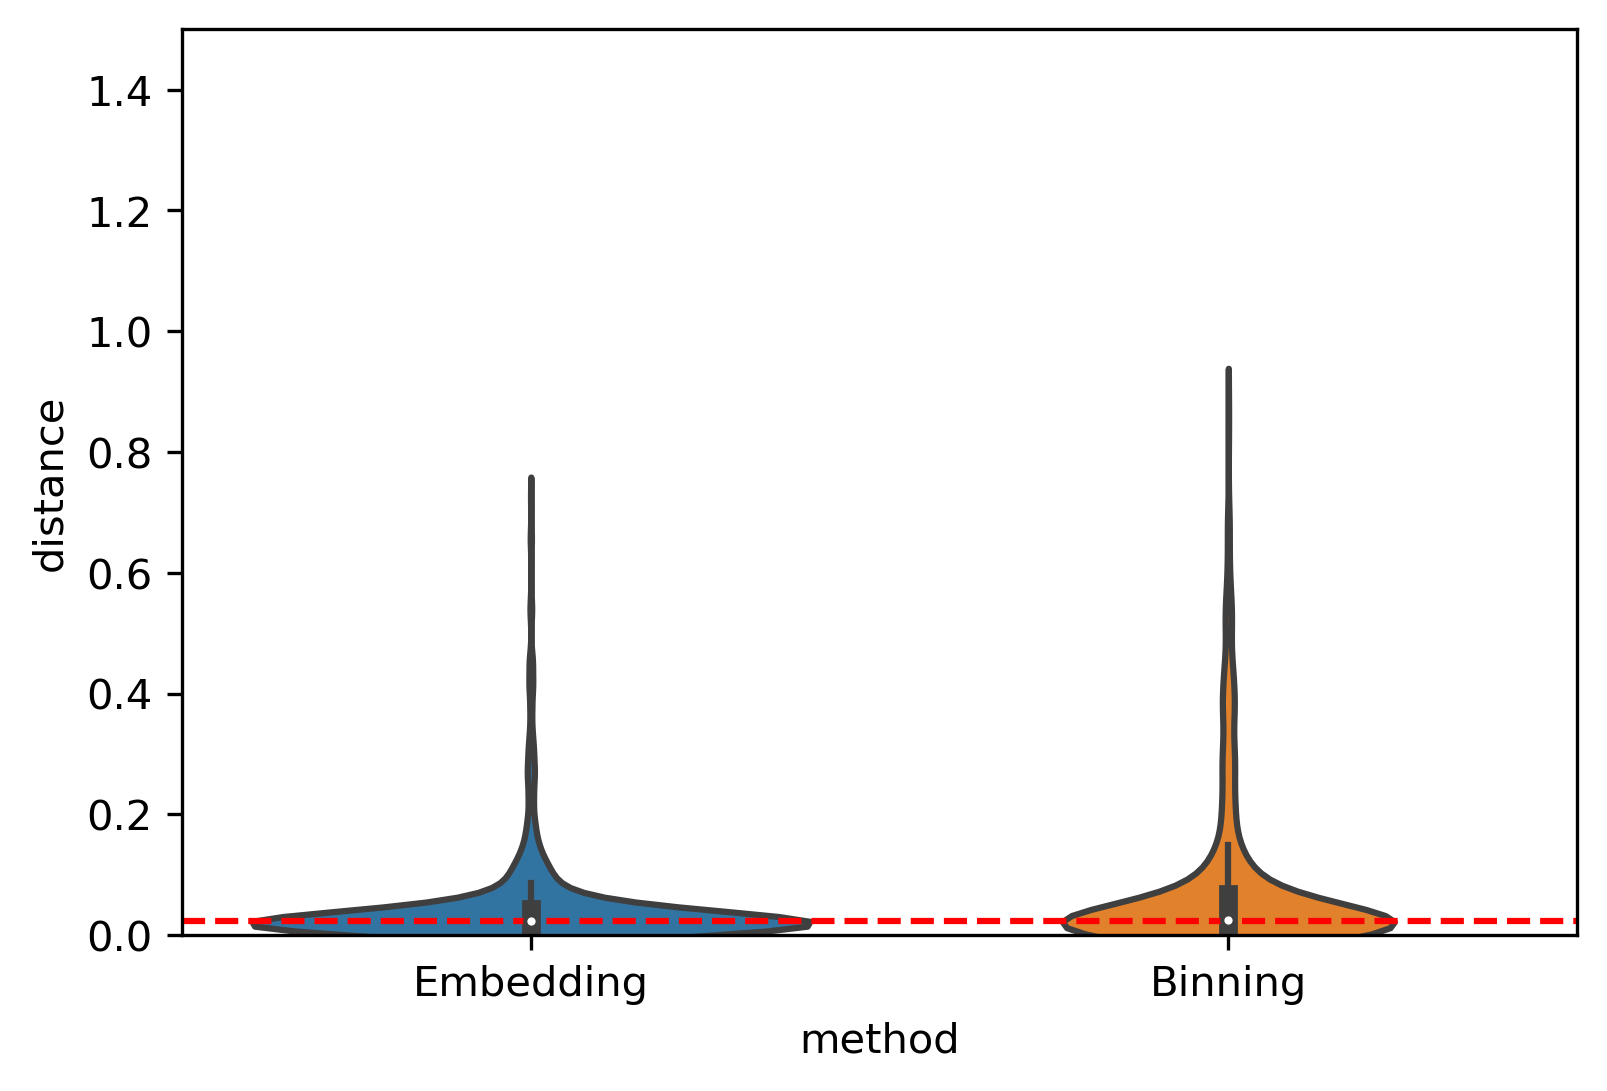

M-RED of embeddings:0.023574227
M-RED of binnings:0.025487045
SD-RED of embeddings:0.07143801
SD-RED of binnings:0.124455206


In [7]:
#divide the Euclidean distance by the maximum distance in space
#calculate RED
all_dist_bins_umap1=all_dist_bins_umap/max_bins
all_dist_embeds_umap1=all_dist_embeds_umap/max_embeds
#the violin plot of relative Euclidean distance (RED) between predicted and experimental spectral Word2vec embeddings and binning vectors of all 1413 molecules. 
df = pd.DataFrame({'method': n*['Embedding'] + n*['Binning'],
                   'distance': list(all_dist_embeds_umap1) + list(all_dist_bins_umap1)})
plt.figure(dpi = 300)
sns.violinplot(data = df, x = 'method', y = 'distance')
plt.ylim(0, 1.5)
plt.axhline(np.median(all_dist_embeds_umap1), linestyle = '--', color = 'red')
plt.savefig('H:/yang/FastEI/response/data_response/volin_RED.tif',dpi=300)
plt.show()
#calculate the M-RED represents the median of RED
np.median(all_dist_bins_umap1)
np.median(all_dist_embeds_umap1)
print('M-RED of embeddings:'+str(np.median(all_dist_embeds_umap1)))
print('M-RED of binnings:'+str(np.median(all_dist_bins_umap1)))
#calculate the SD-RED represents the standard deviation of RED.
np.std(all_dist_bins_umap1)
np.std(all_dist_embeds_umap1)
print('SD-RED of embeddings:'+str(np.std(all_dist_embeds_umap1)))
print('SD-RED of binnings:'+str(np.std(all_dist_bins_umap1)))